### Organizing EEG Data  
  
The purpose of this notebook is to write code that concatenates my EEG data so that I can load it in with MNE and then create epochs. The initial idea is to concatenate EEGs by patient ID, so every unique patient's EEG data is in a single matrix.  
  
The question from there, though, is how to handle the sub EEG overlap because every sub EEG has been classified and almost every sub EEG overlaps substantially with another sub EEG. How do I keep track of which subset belongs to which brain activity type?

How do I handle overlapping sections given they've been classified twice? If one sub EEG starts at 0 seconds and the next starts at 4s, 46s of those sub EEGs overlap with one another. That 46s essentially has two classifications. Usually the classifications are the same. Both sub EEGs would be LRDA, for example. Or both would be GRDA. But, there are instances I think where within a whole EEG, not all sub EEGs belong to the same brain activity type.

In [2]:
import numpy as np
import pandas as pd
import fastparquet, pyarrow

In [3]:
df = pd.read_csv('working_data.csv')

In [4]:
multitypes = []
for i in np.unique(df['eeg_id']):
    n_df = df[df['eeg_id'] == i]
    total_types = len(np.unique(n_df['expert_consensus']))
    if total_types > 1:
        multitypes.append(i)

In [5]:
random_eeg = np.random.choice(multitypes, size = 1)[0]

In [6]:
df[df['eeg_id'] == random_eeg]['expert_consensus'].value_counts()

expert_consensus
Other    3
GRDA     1
Name: count, dtype: int64

In [7]:
random_eeg

1341661057

In [8]:
overlap_example_seconds = df[df['eeg_id'] == random_eeg]['eeg_label_offset_seconds']
overlap_example_types = df[df['eeg_id'] == random_eeg]['expert_consensus']

In [9]:
overlap_example = pd.DataFrame([overlap_example_seconds, overlap_example_types]).transpose()

In [10]:
overlap_example.index = ['Sub EEG {}'.format(i + 1) for i in range(overlap_example.shape[0])]

In [11]:
overlap_example.index.name = 'Overlap Discrepancy'

In [12]:
overlap_example

,eeg_label_offset_seconds,expert_consensus
Overlap Discrepancy,,
Sub EEG 1,0.0,GRDA
Sub EEG 2,40.0,Other
Sub EEG 3,42.0,Other
Sub EEG 4,46.0,Other


### Handling Overlapping Sub EEG Discrepancies  
  
This is being done before sorting by patient ID because looping over unique EEG IDs and concatenating the rows of metadata I want will result in metadata sorted by EEG ID and then sorting by patient ID will need to be done again.

In [13]:
metadata = df[df['eeg_id'] == df['eeg_id'][0]].copy()
unique_eegs = np.unique(df['eeg_id'])
exclude = df['eeg_id'][0]

In [14]:
for eeg in unique_eegs:
    if eeg != exclude:
        subset = df[df['eeg_id'] == eeg].copy()
        activity_type = subset['expert_consensus'].value_counts().index[0]
        uniform_subset = subset[subset['expert_consensus'] == activity_type].copy()
        metadata = pd.concat([metadata, uniform_subset])

In [15]:
metadata = metadata.reset_index().drop(columns = 'index')

In [17]:
metadata.to_csv('metadata_80.csv', index = None)

The result of removing overlapping sub EEGs belonging to different categories of brain activity was 3% of the data removed. This isn't a significant amount of data, especially relative to the amount of data being handled. There are still 80k sub EEGs to work with in the dataset.

In [15]:
dropped = df.shape[0] - metadata.shape[0]
percent_dropped = dropped / df.shape[0]

In [16]:
percent_dropped

0.030251816799053574

It isn't likely this affected the distribution of the target variable much, but it's good to check anyways. The target variable distribution is shown below before and after overlapping discrepancy removal and the difference isn't substantial. The order of most represented to least represented doesn't change, and there isn't a more than 1% change to the ratio of any of the target values.

In [17]:
df['expert_consensus'].value_counts(normalize = True)

expert_consensus
Seizure    0.209216
Other      0.189732
GPD        0.157017
GRDA       0.155822
LRDA       0.146853
LPD        0.141360
Name: proportion, dtype: float64

In [18]:
metadata['expert_consensus'].value_counts(normalize = True)

expert_consensus
Seizure    0.208335
Other      0.187484
GPD        0.159277
GRDA       0.158442
LRDA       0.147700
LPD        0.138762
Name: proportion, dtype: float64

In [19]:
before = df['expert_consensus'].value_counts(normalize = True)

In [20]:
after = metadata['expert_consensus'].value_counts(normalize = True)

In [21]:
overlap_table = pd.DataFrame([before, after], index = ['Before', 'After'])

In [22]:
overlap_table['Total'] = [df.shape[0], metadata.shape[0]]
overlap_table['Percent Difference'] = ['', percent_dropped]

In [23]:
overlap_table = overlap_table.transpose()

In [24]:
overlap_table.index.name = 'Overlap Difference'

In [25]:
overlap_table

,Before,After
Overlap Difference,,
Seizure,0.209216,0.208335
Other,0.189732,0.187484
GPD,0.157017,0.159277
GRDA,0.155822,0.158442
LRDA,0.146853,0.1477
LPD,0.14136,0.138762
Total,82838,80332
Percent Difference,,0.030252


##### Sorting by Patient ID  
  
The code below sorts the metadata by patient ID.

In [26]:
patient_list = np.unique(metadata['patient_id'])

In [27]:
df_patient = metadata[metadata['patient_id'] == patient_list[0]].copy()
df_patient = df_patient.reset_index().drop(columns = 'index')

In [28]:
for i in range(1, len(patient_list)):
    n_df = metadata[metadata['patient_id'] == patient_list[i]].copy()
    df_patient = pd.concat([df_patient, n_df])

In [29]:
df_patient.shape[0]

80332

### Function to Concatenate EEGs by Patient ID

In [30]:
len(np.unique(metadata['patient_id']))

1778

In [31]:
metadata['expert_consensus'].value_counts()['LPD']

11147

In [32]:
32 * 200

6400

In [33]:
workflow = ['Data Loading and Organizing', 'Scaling', 'Filtering', 'Artifact Handling', 
            'Dimensionality Reduction', 'Feature Extraction', 'Modeling and Evaluation']
plans = ['Group by Patient', 'Standardize Individual Channels', 'Bandpass and Notch', 
        'ICA (Ocular/Cardiac)', 'Regional Signal Averaging', 'Band Power/Nonlinear', 
         'Random Forest/Ensembling']

pd.DataFrame([workflow, plans], index = ['General', 'Specific'], 
             columns = ['Step {}'.format(i + 1) for i in range(len(workflow))]).transpose()

,General,Specific
Step 1,Data Loading and Organizing,Group by Patient
Step 2,Scaling,Standardize Individual Channels
Step 3,Filtering,Bandpass and Notch
Step 4,Artifact Handling,ICA (Ocular/Cardiac)
Step 5,Dimensionality Reduction,Regional Signal Averaging
Step 6,Feature Extraction,Band Power/Nonlinear
Step 7,Modeling and Evaluation,Random Forest/Ensembling


In [34]:
metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,row
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,1
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,2
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,3
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,4293144208,1,6.0,1224582295,2,240.0,1525390297,64445,Other,0,0,0,0,0,3,49063
80328,4293306306,0,0.0,819682076,3,168.0,1974235411,37409,GPD,0,1,6,0,2,6,34340
80329,4293354003,0,0.0,1188113564,0,0.0,447244163,16610,GRDA,0,0,0,0,1,1,47742
80330,4293843368,0,0.0,1549502620,0,0.0,1618953053,15065,GRDA,0,0,0,0,1,1,61285


In [35]:
def within_eeg(data, eeg_id):
    subset = data[data['eeg_id'] == eeg_id].copy()
    subset = subset.reset_index().drop(columns = 'index')
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(eeg_id), engine = 'pyarrow')
    full = eeg[0:10000].copy()
    for i in range(1, subset.shape[0]):
        start = int(subset['eeg_label_offset_seconds'][i] * 200)
        stop = start + 10000
        sub_eeg = eeg[start:stop].copy()
        full = pd.concat([full, sub_eeg])
    return full.reset_index().drop(columns = 'index')

In [36]:
within_eeg(metadata, metadata['eeg_id'][0])

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,-144.660004,-147.809998,-129.820007,-129.460007,-157.509995,-124.000000,-124.570000,-94.820000,-153.070007,-121.110001,-86.459999,-132.520004,-138.339996,-128.970001,-71.300003,-114.480003,-86.709999,-114.959999,-81.500000,-20.070000
89996,-140.880005,-153.000000,-129.529999,-129.020004,-154.059998,-131.220001,-128.380005,-95.000000,-140.820007,-114.639999,-84.379997,-115.339996,-119.230003,-114.709999,-70.989998,-92.129997,-79.639999,-116.139999,-81.879997,10.600000
89997,-133.729996,-141.770004,-121.900002,-122.370003,-158.750000,-123.550003,-127.730003,-93.089996,-125.230003,-106.489998,-83.419998,-112.720001,-103.209999,-107.629997,-61.869999,-97.910004,-77.150002,-106.500000,-75.339996,-2.060000
89998,-141.449997,-151.139999,-127.190002,-128.699997,-163.460007,-124.309998,-129.479996,-94.419998,-140.869995,-113.339996,-83.519997,-129.300003,-118.650002,-117.589996,-71.879997,-99.279999,-83.900002,-116.160004,-81.410004,2.820000


In [37]:
def within_patient(data, patient):
    patient_data = data[data['patient_id'] == patient].copy()
    patient_data = patient_data.reset_index().drop(columns = 'index')
    unique_eegs = np.unique(patient_data['eeg_id'])
    full = within_eeg(patient_data, unique_eegs[0])
    for i in range(1, len(unique_eegs)):
        eeg = within_eeg(patient_data, unique_eegs[i])
        full = pd.concat([full, eeg])
    return full.reset_index().drop(columns = 'index')

In [38]:
patient1 = within_patient(metadata, patient_list[0])

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
patient1

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-34.130001,-46.560001,-8.80,-16.450001,-31.600000,-3.07,-29.070000,-9.30,-22.070000,6.110000,3.41,5.34,5.03,-23.129999,-26.580000,-17.690001,-20.330000,-31.160000,-4.43,-1.330000
1,-35.490002,-45.820000,-6.61,-15.220000,-30.690001,-1.43,-26.490000,-7.26,-20.870001,8.810000,6.31,4.03,6.69,-21.680000,-24.590000,-14.710000,-18.160000,-28.870001,-1.56,1.140000
2,-33.939999,-48.820000,-11.45,-19.410000,-32.520000,-5.84,-31.469999,-13.45,-22.209999,3.800000,0.45,6.12,4.80,-25.660000,-30.209999,-19.090000,-23.610001,-34.439999,-6.07,-10.550000
3,-33.660000,-48.169998,-11.00,-18.100000,-32.820000,-4.36,-30.299999,-11.55,-22.450001,4.700000,1.91,6.15,4.92,-25.379999,-28.360001,-18.600000,-23.110001,-33.259998,-5.97,-17.150000
4,-35.020000,-44.500000,-5.57,-13.680000,-30.889999,0.60,-25.260000,-5.53,-20.770000,9.350000,7.73,3.43,7.62,-20.260000,-23.250000,-13.940000,-17.360001,-27.040001,0.11,-9.110000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519995,-31.540001,-39.070000,-0.95,-15.920000,-23.059999,4.07,-20.950001,9.36,-15.300000,313.750000,15.50,5.86,4.48,-23.110001,3.940000,-9.140000,-17.520000,-24.600000,0.12,-63.450001
519996,-31.719999,-45.400002,-9.14,-23.110001,-27.420000,-5.73,-31.459999,-1.63,-17.209999,307.660004,7.98,8.36,0.90,-30.190001,-4.410000,-15.950000,-25.389999,-32.849998,-8.49,6.010000
519997,-33.799999,-45.020000,-6.97,-21.090000,-28.180000,-3.59,-28.820000,2.22,-17.290001,309.140015,9.96,5.84,0.85,-28.049999,-0.880000,-15.070000,-23.049999,-28.600000,-4.94,21.770000
519998,-33.259998,-39.060001,-1.35,-15.620000,-23.860001,3.24,-21.680000,9.72,-14.620000,313.859985,16.17,5.65,4.89,-22.500000,5.520000,-9.500000,-16.700001,-21.340000,1.98,64.639999


In [41]:
patient2 = within_patient(metadata, patient_list[1])
patient3 = within_patient(metadata, patient_list[2])
patient4 = within_patient(metadata, patient_list[3])
patient5 = within_patient(metadata, patient_list[4])
patient6 = within_patient(metadata, patient_list[5])
patient7 = within_patient(metadata, patient_list[6])
patient8 = within_patient(metadata, patient_list[7])
patient9 = within_patient(metadata, patient_list[8])
patient10 = within_patient(metadata, patient_list[9])

In [42]:
n_rows = [patient1.shape[0], patient2.shape[0], patient3.shape[0], patient4.shape[0], 
         patient5.shape[0], patient6.shape[0], patient7.shape[0], patient8.shape[0], 
         patient9.shape[0], patient10.shape[0]]

n_sub_eegs = [patient1.shape[0] / 10000, patient2.shape[0] / 10000, patient3.shape[0] / 10000,
              patient4.shape[0] / 10000, patient5.shape[0] / 10000, patient6.shape[0] / 10000, 
              patient7.shape[0] / 10000, patient8.shape[0] / 10000, patient9.shape[0] / 10000, 
              patient10.shape[0] / 10000]

for i in range(len(n_sub_eegs)):
    n_sub_eegs[i] = int(n_sub_eegs[i])


pd.DataFrame([n_rows, n_sub_eegs], index = ['Number of Rows', 'Number of Sub EEGs'], 
             columns = ['Patient {}'.format(i + 1) for i in range(10)]).transpose()

,Number of Rows,Number of Sub EEGs
Patient 1,520000,52
Patient 2,380000,38
Patient 3,90000,9
Patient 4,590000,59
Patient 5,90000,9
Patient 6,510000,51
Patient 7,200000,20
Patient 8,40000,4
Patient 9,570000,57
Patient 10,670000,67


In [43]:
def standardize_channel(eeg, channel):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(eeg[[channel]]).flatten()
    return scaled

In [44]:
def standardize_eeg(eeg):
    channels = eeg.columns
    for channel in channels:
        eeg[channel] = standardize_channel(eeg, channel)
    return eeg

In [45]:
patient1_scaled = patient1.copy()

In [46]:
patient1_scaled = standardize_eeg(patient1_scaled)

### Notes  
  
The concatenation of sub EEGs results in 520k rows of EEG data for the first patient. This patient has 52 sub EEGs. The next steps are epoching and scaling this data. Eventually I'll need to code everything together in a chain so that for each patient in the dataset it runs through every step (data loading, organizing, re-referencing, scaling, filtering, artifact handling, baseline correcting, and then feature extraction). It does all of this for the first patient and then moves on to the next patient and runs through every step. And then the next patient. And so on.

In [66]:
%matplotlib inline

In [68]:
!pip install PyQt5

     |████████████████████████████████| 3.2 MB 2.8 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... error
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 /tmp/tmpvk_039ft prepare_metadata_for_build_wheel /tmp/tmp2qn3zb8o
         cwd: /tmp/pip-install-rpkmje9f/PyQt5
    Complete output (31 lines):
    Traceback (most recent call last):
      File "/tmp/tmpvk_039ft", line 126, in prepare_metadata_for_build_wheel
        hook = backend.prepare_metadata_for_build_wheel
    AttributeError: module 'sipbuild.api' has no attribute 'prepare_metadata_for_build_wheel'
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/tmp/tmpvk_039ft", line 280, in <module>
        main()
      File "/tmp/tmpvk_039ft", line 263, in main
        json_out['return_val'] = hook(**hook_input['kwargs'])
      File "

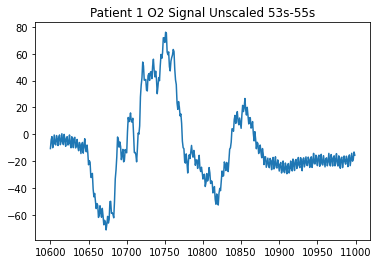

In [47]:
import matplotlib.pyplot as plt

plt.plot(patient1['O2'][10600:11000])
plt.title('Patient 1 O2 Signal Unscaled 53s-55s')
plt.show()

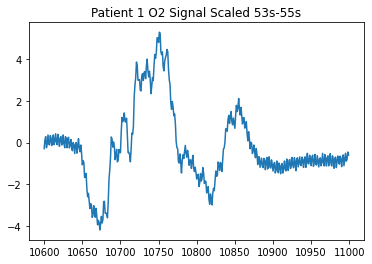

In [48]:
plt.plot(patient1_scaled['O2'][10600:11000])
plt.title('Patient 1 O2 Signal Scaled 53s-55s')
plt.show()

In [49]:
import mne

In [50]:
info = mne.create_info(
    patient1_scaled.columns.to_list(),
    ch_types=(["eeg"]*(len(patient1_scaled.columns)-1))+['ecg'],
    sfreq=200
)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [51]:
raw = mne.io.RawArray(
    patient1_scaled.to_numpy().T*1e-6,
    info
)

Creating RawArray with float64 data, n_channels=20, n_times=520000
    Range : 0 ... 519999 =      0.000 ...  2599.995 secs
Ready.


### Notes on Plots for the First Patient  
  
First I plotted the data from 50s to 55s. This marks the beginning of the second sub EEG in this patient's data since the data here is just 50s sub EEGs concatenated. Then I plotted the signals from 53s to 55s and from 50s to 52s to see if I could get a better understanding of what might be happening between 50s and 55s.  
  
The signals for every channel look very similar. These aren't flat lines. The signals do oscillate between low and high points across time, but the overall trend is unchanging for most the data from 50s to 55s. Then there's a section between 53s and 55s where this is no longer true and there's substantial change in the trend until the signals return to the trend shown at the start of this 5s subset.  
  
It might be that this section is representative of a certain type of activity, but I'm going to try scaling and plotting again. I don't think that will change much, but difference in amplitude range between the channels can skew the visualization and make things more difficult to read. In some instances the ranges of channels are so much larger than other channels that their signals cover the signals of surrounding channels. This isn't an example of that. I think what's happening here is either an artifact or an instance of one of the type of activity in question. Maybe the patient had a seizure within these two seconds of EEG.

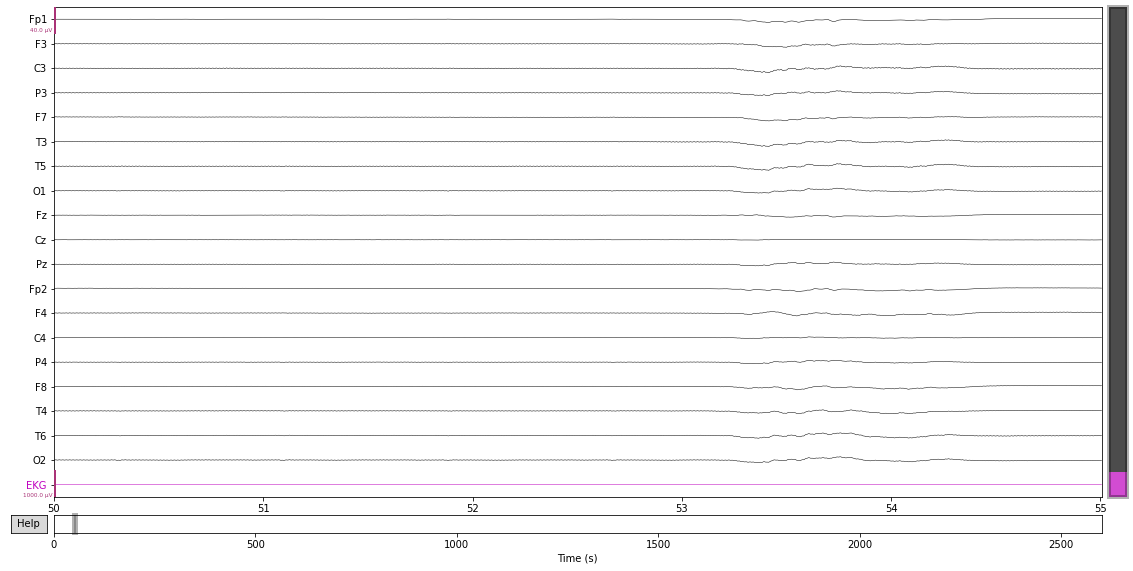

In [67]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw.plot(start=50, duration=5)
plt.show()

In [53]:
info1 = mne.create_info(
    patient1.columns.to_list(),
    ch_types=(["eeg"]*(len(patient1.columns)-1))+['ecg'],
    sfreq=200
)
info1.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [54]:
raw1 = mne.io.RawArray(
    patient1.to_numpy().T*1e-6,
    info1
)

Creating RawArray with float64 data, n_channels=20, n_times=520000
    Range : 0 ... 519999 =      0.000 ...  2599.995 secs
Ready.


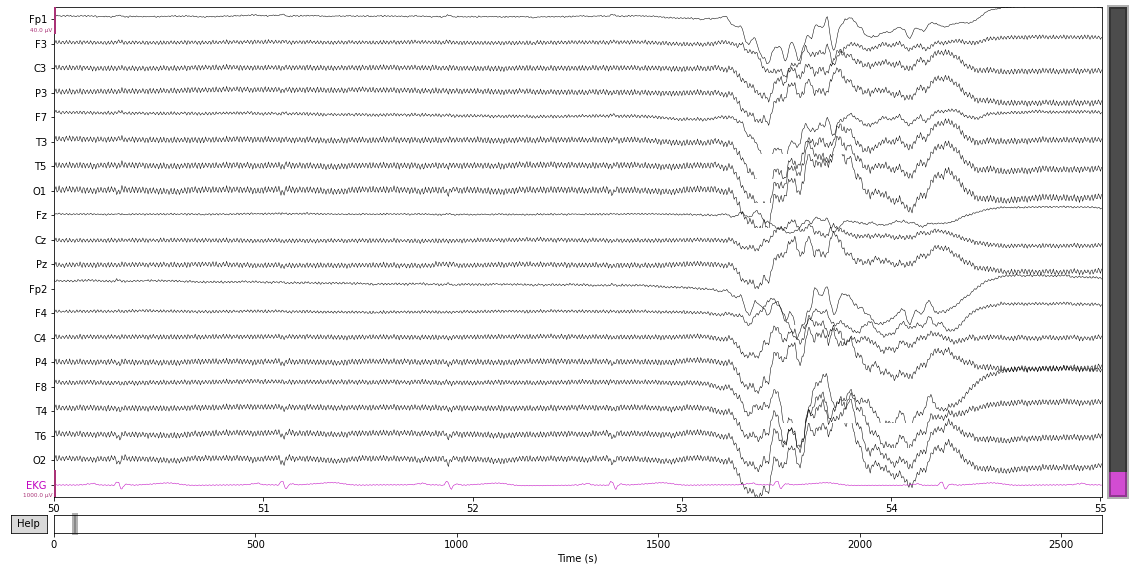

In [55]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw1.plot(start=50, duration=5)
plt.show()

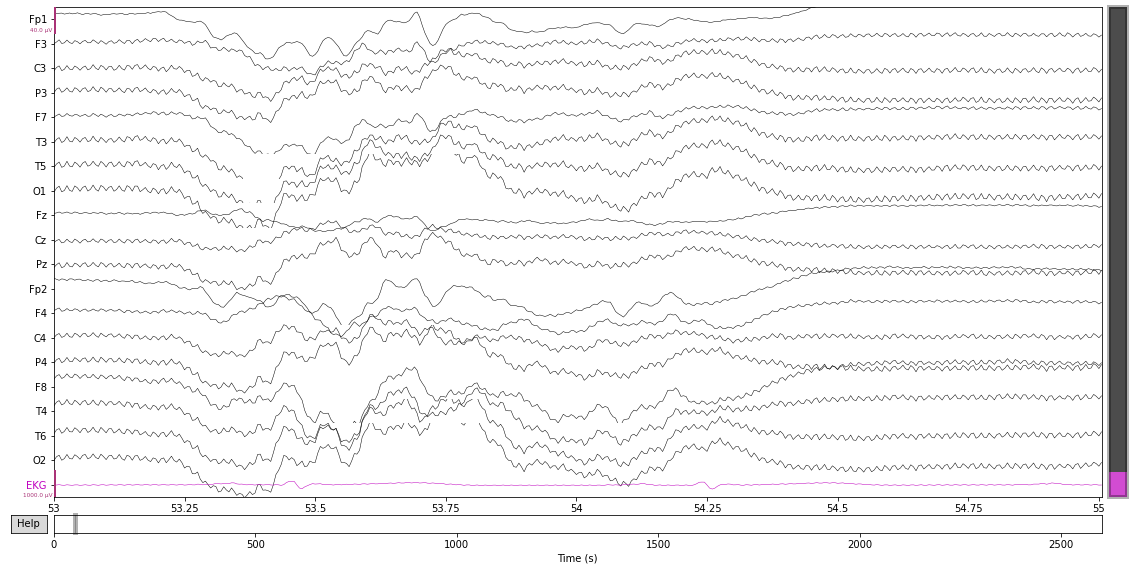

In [56]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw1.plot(start=53, duration=2)
plt.show()

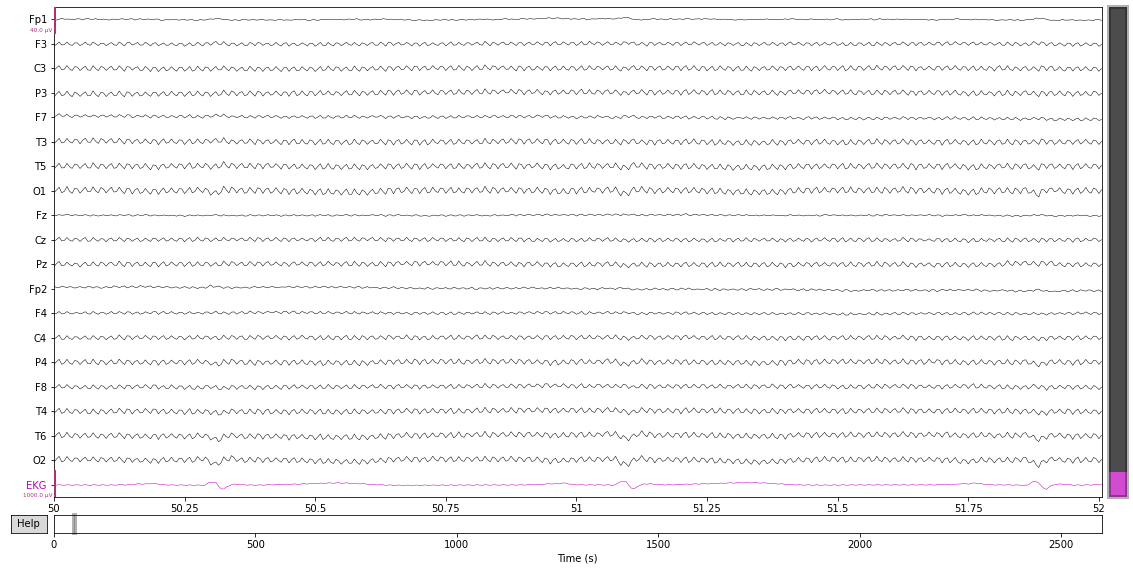

In [57]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw1.plot(start=50, duration=2)
plt.show()

In [58]:
from mne.decoding import Scaler

In [70]:
scaler = Scaler(scalings = 'mean')

This  works similar to sklearn's StandardScaler in that you create an instance of the scaler and then fit that instance to your data and transform your data. The issue I'm having is I don't know what to pass it because it isn't as straightforward as just passing it the pandas df or some subset of the pandas df. The documentation says you pass it epochs_data, but looking at the example I'm still confused by what that is. They set up a pipeline with the scaler as part of the pipeline. The instance is created as Scaler(epochs.info), but I don't know what that means.

In [62]:
raw1_scaled = scaler.fit_transform(raw1.get_data())

In [64]:
raw1_scaled

array([[[-1.25677342],
        [-1.42751262],
        [-1.09003616],
        ...,
        [-0.51349367],
        [-0.59711817],
        [-0.52392831]],

       [[-2.08597253],
        [-2.10188695],
        [-2.08746799],
        ...,
        [-0.66911672],
        [-0.67660785],
        [-0.68588742]],

       [[ 0.43297792],
        [ 0.45786292],
        [ 0.41750703],
        ...,
        [-0.14135762],
        [-0.15978794],
        [-0.17772704]],

       ...,

       [[-1.05864633],
        [-0.99533865],
        [-1.12355203],
        ...,
        [-0.44136891],
        [-0.4337532 ],
        [-0.48004171]],

       [[ 0.72449843],
        [ 0.78754252],
        [ 0.77813761],
        ...,
        [-0.11320122],
        [-0.1141499 ],
        [-0.15761802]],

       [[ 0.93129785],
        [ 0.96380685],
        [ 0.47783555],
        ...,
        [ 0.25727042],
        [ 0.74461266],
        [ 0.94484549]]])